In [1]:
from file_py.run_log_parser import RunLogParser
from file_py.csv_preprocessing_scaler import CsvPreprocessingScaler
from itertools import combinations, permutations, product
import pandas as pd
from collections import Counter

In [2]:
df = CsvPreprocessingScaler.read_csv_file("file_csv/LogSplunkWF_24_06.csv")

In [3]:
result_df_Raw = RunLogParser.process_attacks('file_csv/attackLog_24_06.csv', CsvPreprocessingScaler.RawPreprocessingWSig(df))

# Patterns

In [4]:
# Read the CSVs into Pandas Dataframes
df_attack_log = pd.read_csv("file_csv/attackLog_24_06.csv")

# Convert relevant columns to datetime for subsequent analysis
df_attack_log['Data inizio attacco'] = pd.to_datetime(df_attack_log['Data inizio attacco'])
df_attack_log['Data fine attacco'] = pd.to_datetime(df_attack_log['Data fine attacco'])

In [5]:
# lista degli eventi
events = []
single_attack = {'RuleAnnotation.mitre_attack.id': [], 'severity_id': [], 'EventType': [], 'tag': [], 'signature': []}  # Inizializza il dizionario fuori dal ciclo
for _, attack in df_attack_log.iterrows():
    # Filter results that fall within the attack time window
    mask = (result_df_Raw['_time'] >= attack['Data inizio attacco']) & (result_df_Raw['_time'] <= attack['Data fine attacco'])
    df_filtered = result_df_Raw.loc[mask].copy()
    for _, row in df_filtered.iterrows():
        single_attack['RuleAnnotation.mitre_attack.id'].append(row['RuleAnnotation.mitre_attack.id'])
        single_attack['severity_id'].append(row['severity_id'])
        single_attack['EventType'].append(row['EventType'])
        single_attack['tag'].append(row['tag'])
        single_attack['signature'].append(row['signature'])
    if single_attack['RuleAnnotation.mitre_attack.id']:
        events.append(single_attack)
    single_attack = {'RuleAnnotation.mitre_attack.id': [], 'severity_id': [], 'EventType': [], 'tag': [], 'signature': []}

event=pd.DataFrame(events)

In [7]:
event.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 5 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   RuleAnnotation.mitre_attack.id  116 non-null    object
 1   severity_id                     116 non-null    object
 2   EventType                       116 non-null    object
 3   tag                             116 non-null    object
 4   signature                       116 non-null    object
dtypes: object(5)
memory usage: 4.7+ KB


In [8]:
def filter_rows_with_min_elements(row, columns, min_elements=4):

  for col in columns:
    if len(row[col]) < min_elements:
      return False
  return True

In [9]:
# Define a function to convert string to list
def convert_to_list(s, col_name):
  """
  This function takes a string, removes the characters '[', ']' and "'",
  splits the string and converts each item to integer if the string
  is `severity_id` or `EventType`.
  """
  s = s.replace('[', '').replace(']', '').replace("'", "")
  l = s.split(', ')
  if col_name in ['severity_id', 'EventType']:
    l = [int(i) for i in l]
  return l


In [10]:
# Apply the function to the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  event[col] = event[col].astype(str).apply(lambda x: convert_to_list(x, col))

In [11]:
#Opzionale: per lavorare sugli attacchi che corrispondo ad almeno min_elements elementi
columns_to_check = ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']
filtered_events=event[event.apply(lambda row: filter_rows_with_min_elements(row, columns_to_check), axis=1)]

In [12]:
filtered_events.reset_index(inplace=True)

## Sequenza

Un elenco ordinato di elementi in cui l'ordine è importante. Gli elementi possono ripetersi.

In [13]:

# Create a new dataframe to store the sequences and their frequency
sequences_df = pd.DataFrame(columns=['sequence', 'frequency'])

# Iterate over the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  # Get all unique sequences and their frequency
  sequences = Counter(tuple(seq) for seq in event[col])
  # Convert the sequences to a dataframe
  sequences_df = pd.concat([sequences_df, pd.DataFrame({'sequence': list(sequences.keys()), 'frequency': list(sequences.values())})])

# Get unique sequences and their frequency
sequences_df = sequences_df.groupby('sequence').agg({'frequency': 'sum'}).reset_index()
sequences_df['sequence'] = sequences_df['sequence'].apply(lambda x: list(x))

# Sort the dataframe by frequency in descending order
sequences_df = sequences_df.sort_values(by='frequency', ascending=False)

# print the top 10 sequences
print("Top 10 most frequent sequences are: \n")
print(sequences_df.head(10))

Top 10 most frequent sequences are: 

                                              sequence frequency
302                 [attack\nmalware\nprocess\nreport]        13
301  [attack\nmalware\nprocess\nreport, attack\nmal...        13
135                                           [75, 75]        13
136                                               [75]        13
21                                                 [1]        13
18                                              [1, 1]        13
134                                       [75, 75, 75]         6
185                                            [T1059]         6
133                                   [75, 75, 75, 75]         5
159       [T1003.001, T1003.001, T1003.001, T1003.001]         4


### Filtered

In [14]:
# Create a new dataframe to store the sequences and their frequency
sequences_df = pd.DataFrame(columns=['sequence', 'frequency'])

# Iterate over the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  # Get all unique sequences and their frequency
  sequences = Counter(tuple(seq) for seq in filtered_events[col])
  # Convert the sequences to a dataframe
  sequences_df = pd.concat([sequences_df, pd.DataFrame({'sequence': list(sequences.keys()), 'frequency': list(sequences.values())})])

# Get unique sequences and their frequency
sequences_df = sequences_df.groupby('sequence').agg({'frequency': 'sum'}).reset_index()
sequences_df['sequence'] = sequences_df['sequence'].apply(lambda x: list(x))

# Sort the dataframe by frequency in descending order
sequences_df = sequences_df.sort_values(by='frequency', ascending=False)

# print the top 10 sequences
print("Top 10 most frequent sequences are: \n")
print(sequences_df.head(10))

Top 10 most frequent sequences are: 

                                              sequence frequency
106                                   [75, 75, 75, 75]         5
99   [75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 7...         4
214  [attack\nmalware\nprocess\nreport, attack\nmal...         4
38                                        [3, 3, 3, 3]         4
3        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]         4
128       [T1003.001, T1003.001, T1003.001, T1003.001]         4
202  [attack\nendpoint\nfilesystem\nmalware, attack...         4
137  [T1049, T1069.002, T1482, T1135, T1033, T1059,...         4
100  [75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 75, 7...         3
105                               [75, 75, 75, 75, 75]         2


## Permutazione

Un modo specifico di ordinare tutti gli elementi di un insieme. L'ordine è cruciale, e ogni elemento viene utilizzato una sola volta.

In [15]:
# Create a new dataframe to store the permutations and their frequency
permutations_df = pd.DataFrame(columns=['permutation', 'frequency'])

# Iterate over the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  # Get all unique permutations and their frequency
  perms = Counter(tuple(perm) for l in filtered_events[col] for perm in permutations(set(l), 4))#len(set(l)


  # Convert the permutations to a dataframe
  permutations_df = pd.concat([permutations_df, pd.DataFrame({'permutation': list(perms.keys()), 'frequency': list(perms.values())})])

# Get unique permutations and their frequency
permutations_df = permutations_df.groupby('permutation').agg({'frequency': 'sum'}).reset_index()
permutations_df['permutation'] = permutations_df['permutation'].apply(lambda x: list(x))

# Sort the dataframe by frequency in descending order
permutations_df = permutations_df.sort_values(by='frequency', ascending=False)

# print the top 10 permutations
print("Top 10 permutazioni più frequenti \n")
print(permutations_df.head(10).to_markdown(index=False, numalign="left", stralign="left"))


Top 10 permutazioni più frequenti 

| permutation                                      | frequency   |
|:-------------------------------------------------|:------------|
| ['T1087.002', 'T1482', 'T1069.001', 'T1087']     | 15          |
| ['T1087.002', 'T1069.001', 'T1087', 'T1069.002'] | 15          |
| ['T1482', 'T1087.001', 'T1059.001', 'T1069.001'] | 15          |
| ['T1482', 'T1087.001', 'T1059.001', 'T1069']     | 15          |
| ['T1087', 'T1069.001', 'T1087.002', 'T1087.001'] | 15          |
| ['T1087', 'T1069.001', 'T1087.002', 'T1069.002'] | 15          |
| ['T1087', 'T1069.001', 'T1087.002', 'T1069']     | 15          |
| ['T1087', 'T1069.001', 'T1087.002', 'T1059.001'] | 15          |
| ['T1059.001', 'T1069.001', 'T1087', 'T1482']     | 15          |
| ['T1059.001', 'T1069.001', 'T1087', 'T1087.001'] | 15          |


## Combinazione

Un modo di selezionare un sottoinsieme di elementi da un insieme più grande, dove l'ordine di selezione non è importante.

In [16]:
#Numero elementi
num_elems=3

# Create a new dataframe to store the combinations and their frequency
combinations_df = pd.DataFrame(columns=['combination', 'frequency'])

# Iterate over the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  # Get all unique combinations and their frequency
  combs = Counter(tuple(comb) for l in event[col] for comb in combinations(set(l), num_elems))
  # Convert the combinations to a dataframe
  combinations_df = pd.concat([combinations_df, pd.DataFrame({'combination': list(combs.keys()), 'frequency': list(combs.values())})])

# Get unique combinations and their frequency
combinations_df = combinations_df.groupby('combination').agg({'frequency': 'sum'}).reset_index()
combinations_df['combination'] = combinations_df['combination'].apply(lambda x: list(x))

# Sort the dataframe by frequency in descending order
combinations_df = combinations_df.sort_values(by='frequency', ascending=False)

# print the top 10 combinations
print(f"Top 10 combinazioni più frequenti con almeno {num_elems} elementi: \n")
print(combinations_df.head(10))

Top 10 combinazioni più frequenti con almeno 3 elementi: 

                       combination frequency
7                     [25, 50, 75]        18
911      [T1482, T1069.001, T1087]        15
490  [T1069.001, T1069, T1087.001]        15
413      [T1069, T1087.002, T1087]        15
646  [T1087.002, T1087.001, T1087]        15
414  [T1069, T1087.002, T1087.001]        15
895          [T1482, T1069, T1087]        15
896      [T1482, T1069, T1087.001]        15
897      [T1482, T1069, T1087.002]        15
909      [T1482, T1069.001, T1069]        15


### Filtered

In [17]:
#Numero elementi
num_elems=4

# Create a new dataframe to store the combinations and their frequency
combinations_df = pd.DataFrame(columns=['combination', 'frequency'])

# Iterate over the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  # Get all unique combinations and their frequency
  combs = Counter(tuple(comb) for l in filtered_events[col] for comb in combinations(set(l), num_elems))
  # Convert the combinations to a dataframe
  combinations_df = pd.concat([combinations_df, pd.DataFrame({'combination': list(combs.keys()), 'frequency': list(combs.values())})])

# Get unique combinations and their frequency
combinations_df = combinations_df.groupby('combination').agg({'frequency': 'sum'}).reset_index()
combinations_df['combination'] = combinations_df['combination'].apply(lambda x: list(x))

# Sort the dataframe by frequency in descending order
combinations_df = combinations_df.sort_values(by='frequency', ascending=False)

# print the top 10 combinations
print(f"Top 10 combinazioni più frequenti con almeno {num_elems} elementi: \n")
print(combinations_df.head(10))

Top 10 combinazioni più frequenti con almeno 4 elementi: 

                                   combination frequency
2445          [T1482, T1069, T1087.001, T1087]        15
2453      [T1482, T1069, T1087.002, T1087.001]        15
2452          [T1482, T1069, T1087.002, T1087]        15
2528          [T1482, T1069.001, T1069, T1087]        15
2529      [T1482, T1069.001, T1069, T1087.001]        15
2530      [T1482, T1069.001, T1069, T1087.002]        15
2561  [T1482, T1069.001, T1087.002, T1087.001]        15
2684      [T1482, T1087.002, T1087.001, T1087]        15
1245      [T1069.001, T1069, T1087.001, T1087]        15
2553      [T1482, T1069.001, T1087.001, T1087]        15


## MLXTEND e PrefixSpan Test

### Sequenze frequenti

APRIORI: Un algoritmo utilizzato nel data mining per scoprire frequenti pattern di elementi in grandi insiemi di dati.

In [18]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [19]:
# Funzione per preprocessare le sequenze
def preprocess_sequences(data):
    sequences = data.apply(eval).tolist()
    return sequences

# Preprocessare le colonne di eventi
#event_sequences = preprocess_sequences(event['RuleAnnotation.mitre_attack.id'])
event_sequences=event['RuleAnnotation.mitre_attack.id']
# Utilizzare TransactionEncoder per trasformare le sequenze
te = TransactionEncoder()
te_ary = te.fit(event_sequences).transform(event_sequences)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Applicare l'algoritmo Apriori per trovare sequenze frequenti
frequent_itemsets = apriori(df_trans, min_support=0.1, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False, inplace=True)

# Filtrare per itemset di almeno 3 elementi
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets = frequent_itemsets[frequent_itemsets['length'] >= 2]

print(frequent_itemsets.head(10))

      support                                         itemsets  length
15   0.224138                               (T1059, T1059.001)       2
14   0.181034                               (T1003.001, T1105)       2
131  0.146552                    (T1482, T1087.002, T1069.002)       3
44   0.146552                               (T1482, T1069.002)       2
43   0.146552                           (T1087.002, T1069.002)       2
50   0.146552                               (T1087.002, T1482)       2
337  0.129310  (T1069.001, T1069, T1087.002, T1059.001, T1087)       5
239  0.129310                 (T1482, T1069, T1087, T1069.002)       4
246  0.129310             (T1069, T1087.002, T1087.001, T1482)       4
245  0.129310                 (T1069, T1087.002, T1087, T1482)       4


# Apriori su tutto il dataset event

C:\Users\AlbertiLe\AppData\Local\Temp\ipykernel_118596\3166264222.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sequence_occurrence_confidence['occurrences'] = sequence_occurrence_confidence['support'] * num_transactions


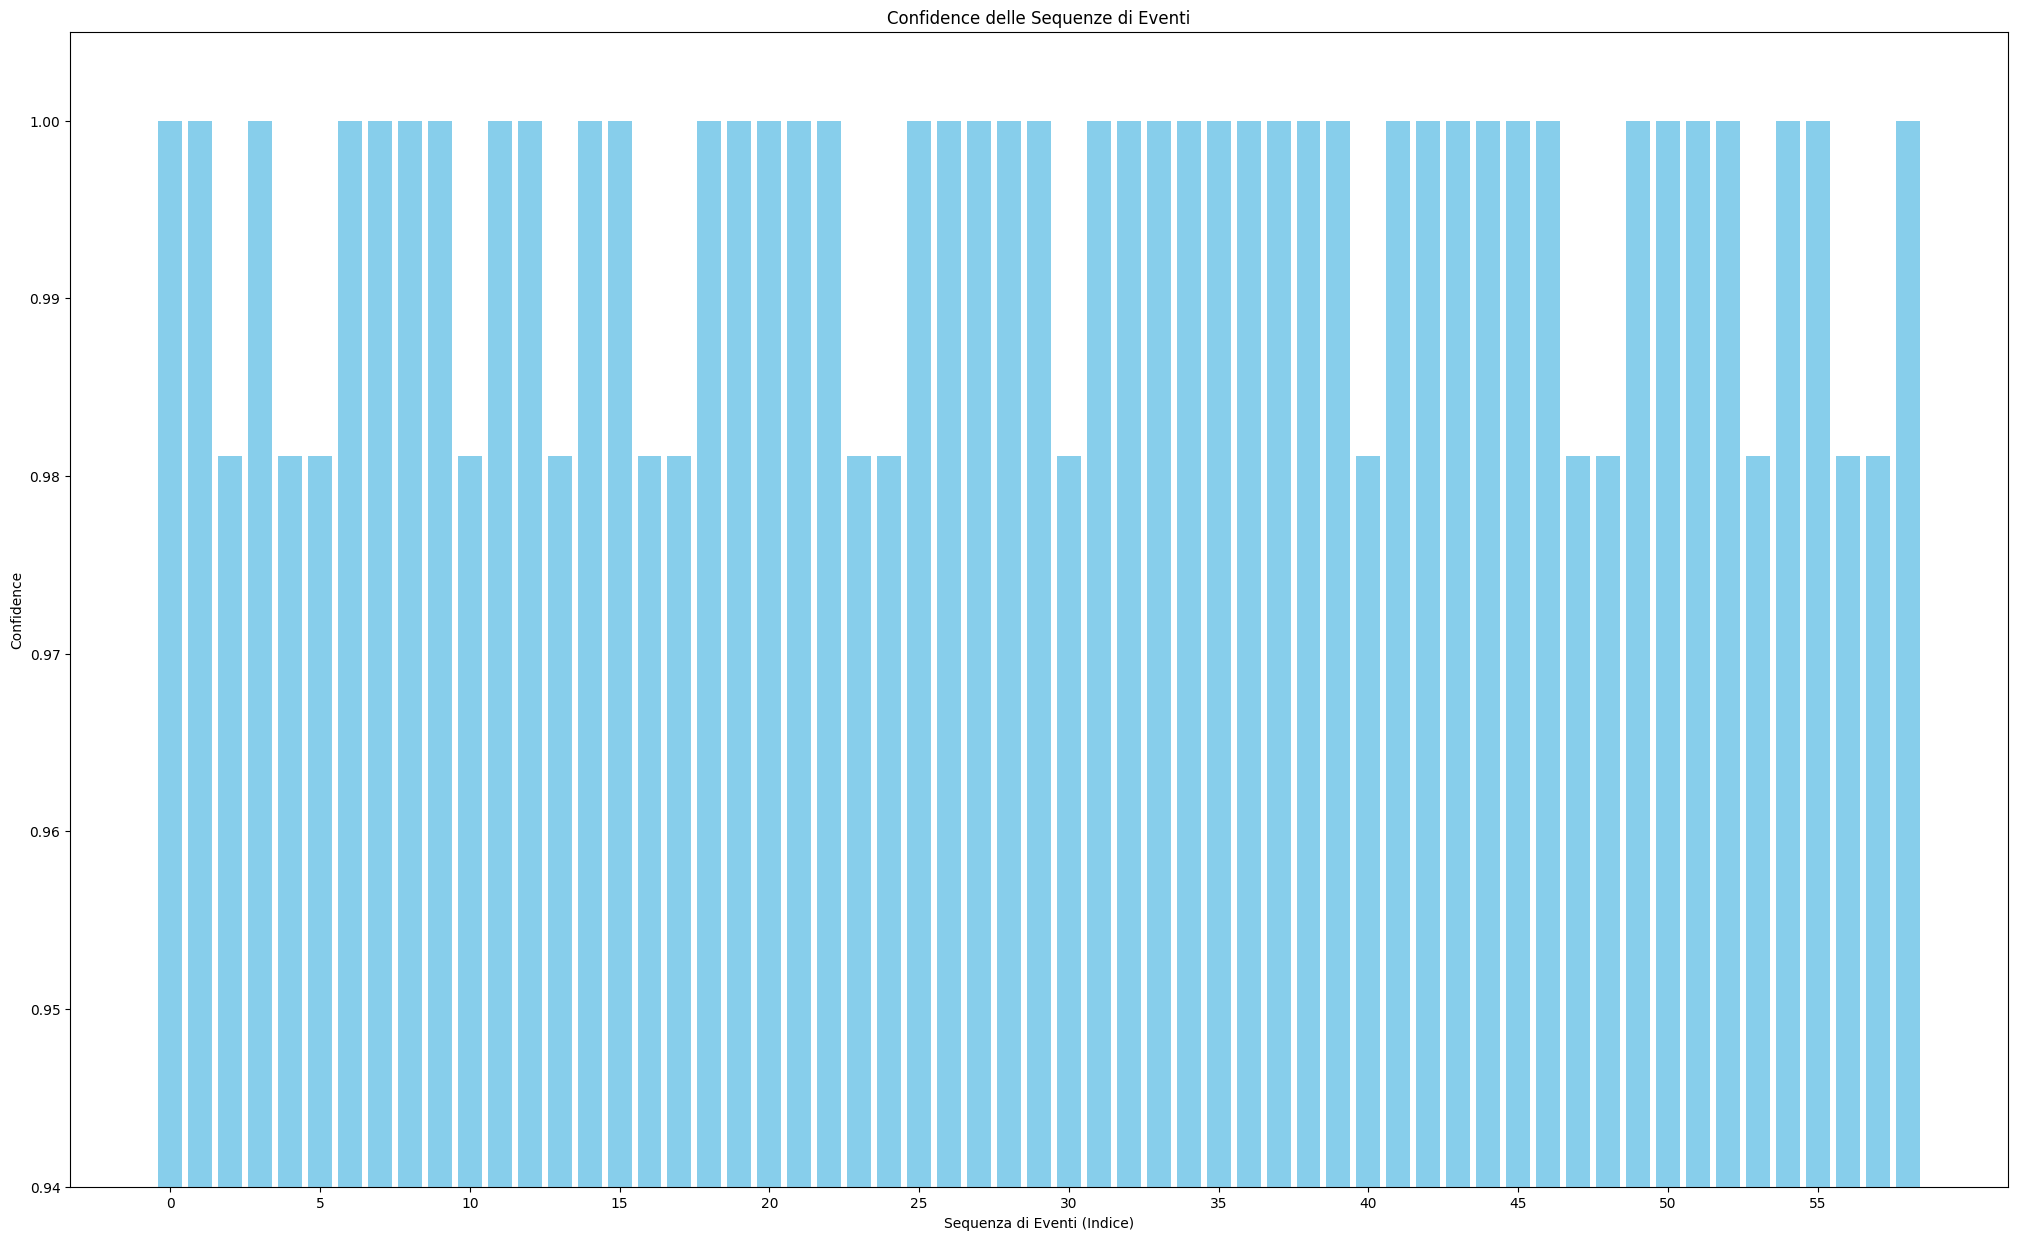

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import ast

df_apriori = event.copy()

# Apply the function to the columns
for col in ['RuleAnnotation.mitre_attack.id', 'severity_id', 'EventType', 'tag']:
  df_apriori[col] = df_apriori[col].astype(str).apply(lambda x: convert_to_list(x, col))

# Trasformazione del dataset in una lista di liste di eventi
df_apriori_list = df_apriori.values.tolist()
transformed_dataset = [sum(row, []) for row in df_apriori_list]

all_sequences = [[str(item) for item in sequence] for sequence in transformed_dataset]

# Applica l'algoritmo Apriori per identificare gli itemset frequenti
te = TransactionEncoder()
te_ary = te.fit(all_sequences).transform(all_sequences)
df_apriori_TE = pd.DataFrame(te_ary, columns=te.columns_)

# Identifica gli itemset frequenti con supporto minimo 0.4
frequent_itemsets = apriori(df_apriori_TE, min_support=0.4, use_colnames=True)
# Genera le regole di associazione con confidence minima 0.95
min_threshold = 0.95
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_threshold)

# Filtra le regole con almeno 3 elementi in antecedente o conseguente
sequence_occurrence_confidence = rules[(rules['antecedents'].apply(len) >= 3) | (rules['consequents'].apply(len) >= 3)]

# Calcola il numero di transazioni nel dataset trasformato
num_transactions = len(df_apriori_TE)
sequence_occurrence_confidence['occurrences'] = sequence_occurrence_confidence['support'] * num_transactions

# Creazione del dizionario che mappa indici a sequenze di eventi con occorrenze
list_sequence_index = []
for idx, (antecedents, consequents) in enumerate(zip(sequence_occurrence_confidence['antecedents'], sequence_occurrence_confidence['consequents'])):
    antecedents_str = ', '.join(antecedents).replace('\n', ' ').replace('\\\\', '/')
    consequents_str = ', '.join(consequents).replace('\n', ' ').replace('\\\\', '/')
    list_sequence_index.append(f"{idx} : {antecedents_str}  ------>  {consequents_str}")

# Plot della confidence delle sequenze di eventi
y_min = min_threshold - 0.01
plt.figure(figsize=(25, 15))
plt.bar(range(len(sequence_occurrence_confidence)), sequence_occurrence_confidence['confidence'], color='skyblue')
plt.xlabel('Sequenza di Eventi (Indice)')
plt.ylabel('Confidence')
plt.title('Confidence delle Sequenze di Eventi')
plt.ylim(y_min, 1.005)
plt.xticks(np.arange(0, len(sequence_occurrence_confidence), step=5), [f"{idx}" for idx in range(0, len(sequence_occurrence_confidence), 5)])
plt.show()

In [21]:
list_sequence_index

['0 : 3, T1003.001, attack/nendpoint/nfilesystem/nmalware  ------>  75',
 '1 : 3, T1003.001, 75  ------>  attack/nendpoint/nfilesystem/nmalware',
 '2 : 3, attack/nendpoint/nfilesystem/nmalware, 75  ------>  T1003.001',
 '3 : attack/nendpoint/nfilesystem/nmalware, T1003.001, 75  ------>  3',
 '4 : 3  ------>  attack/nendpoint/nfilesystem/nmalware, T1003.001, 75',
 '5 : attack/nendpoint/nfilesystem/nmalware  ------>  3, T1003.001, 75',
 '6 : 3, T1003.001, suspicious-unsigned-dbghelp/dbgcore-dll-loaded  ------>  75',
 '7 : 3, T1003.001, 75  ------>  suspicious-unsigned-dbghelp/dbgcore-dll-loaded',
 '8 : 3, suspicious-unsigned-dbghelp/dbgcore-dll-loaded, 75  ------>  T1003.001',
 '9 : T1003.001, suspicious-unsigned-dbghelp/dbgcore-dll-loaded, 75  ------>  3',
 '10 : 3  ------>  T1003.001, suspicious-unsigned-dbghelp/dbgcore-dll-loaded, 75',
 '11 : suspicious-unsigned-dbghelp/dbgcore-dll-loaded  ------>  3, T1003.001, 75',
 '12 : 3, attack/nendpoint/nfilesystem/nmalware, suspicious-unsigned